# Result

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

%matplotlib inline

In [2]:
from methods.evaluation import Evaluation

In [30]:
recall = []
methods, recall_index, datasets = [], [], []
df = pd.DataFrame(columns=['method', 'acc', 'recall@k', 'domain'])

domains = ['eclipse', 'netbeans', 'openoffice']
authors = { 'baseline': 'Deshmukh et al. (2017)', 
            'baseline_dwen': 'Budhiraja et al. (2018)',
            'propose': 'Propose',
            'doc2vec': 'Doc2vec',
           'fasttext': 'FastText'
          }

for domain in domains:
    # Domain to use
    DOMAIN = domain
    # Dataset paths
    DIR = 'data/processed/{}'.format(DOMAIN)

    for method in ['baseline', 'baseline_dwen', 'propose', 'doc2vec', 'fasttext']:
        evaluation = Evaluation(0)
        path = os.path.join(DIR, 'exported_rank_{}.txt'.format(method))
        try:
            report = evaluation.evaluate(path)
            recall.append(report['1 - recall_at_5'])
            recall.append(report['2 - recall_at_10'])
            recall.append(report['3 - recall_at_15'])
            recall.append(report['4 - recall_at_20'])
            recall.append(report['5 - recall_at_25'])
            methods += [authors[method]] * 5
            datasets += [domain] * 5
            recall_index += [5, 10, 15, 20, 25]
            print(path)
        except:
            print("Does not exist result for: {}".format(path))
            pass

df['acc'] = recall
df['recall@k'] = recall_index
df['method'] = methods
df['domain'] = datasets

data/processed/eclipse/exported_rank_baseline.txt
data/processed/eclipse/exported_rank_baseline_dwen.txt
data/processed/eclipse/exported_rank_propose.txt
data/processed/eclipse/exported_rank_doc2vec.txt
data/processed/eclipse/exported_rank_fasttext.txt
data/processed/netbeans/exported_rank_baseline.txt
data/processed/netbeans/exported_rank_baseline_dwen.txt
data/processed/netbeans/exported_rank_propose.txt
Does not exist result for: data/processed/netbeans/exported_rank_doc2vec.txt
data/processed/netbeans/exported_rank_fasttext.txt
data/processed/openoffice/exported_rank_baseline.txt
data/processed/openoffice/exported_rank_baseline_dwen.txt
data/processed/openoffice/exported_rank_propose.txt
Does not exist result for: data/processed/openoffice/exported_rank_doc2vec.txt
data/processed/openoffice/exported_rank_fasttext.txt


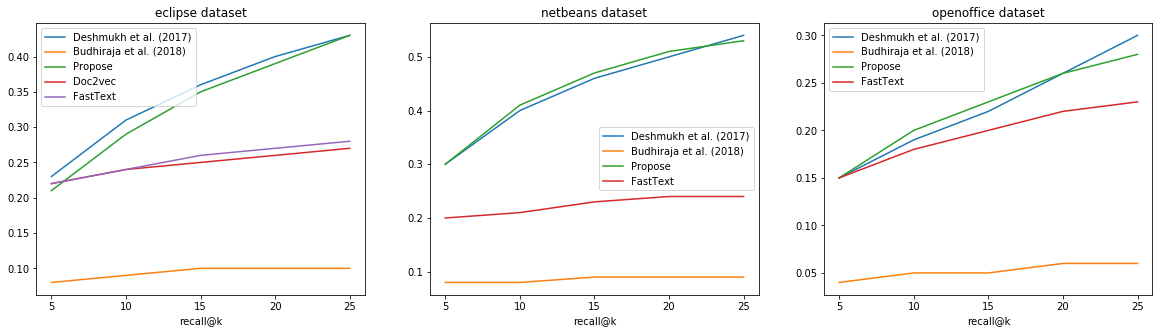

In [31]:
import matplotlib.ticker as mticker

# equivalent but more general
fig, axes = plt.subplots(nrows=1, ncols=len(domains), figsize=(20, 5))

for index, domain in enumerate(domains):
    methods = df['method'].unique()
    for method in methods:
        experiment = df[(df['method'] == method) & (df['domain'] == domain)]
        if experiment.shape[0] > 0:
            experiment.plot(x='recall@k', y='acc', label=method, ax=axes[index])
            
    axes[index].set_title('{} dataset'.format(domain))
    formatter = mticker.ScalarFormatter()
    axes[index].xaxis.set_major_formatter(formatter)
    axes[index].xaxis.set_major_locator(mticker.FixedLocator([5, 10, 15, 20, 25]))